# SVMの仕組みを理解し、実際に学習させてみる

ここでは、SVMの仕組みをexampleコードとグラフ付きで理解し、SVMを実際に学習させてみます。
プログラムの最後には、トレーニングデータの数を変えた時の結果を対話的に比較できるコードもついています。ぜひいろいろと書き換えて結果を見比べてみて、理解を深めてみてください。

## 1. ライブラリのインポートとデータセットの用意

まず、必要なライブラリをインポートします。

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

次に、2クラスにクラス分けされたトレーニングデータセットを用意します。

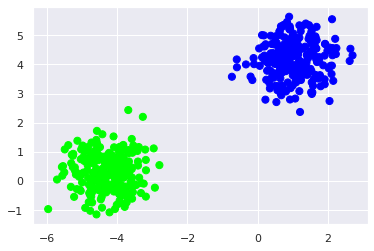

In [47]:
#from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, centers=2,
                  random_state=3, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='brg');

## 2. クラスによるデータの決定境界

この2つのクラスをうまく分割する直線(決定境界)を引くことを考えます。

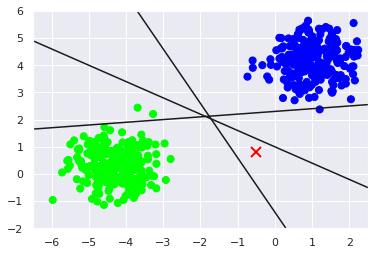

In [27]:
xfit = np.linspace(-6.5, 2.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='brg')
plt.plot([-0.5], [0.8], 'x', color='red', markeredgewidth=2, markersize=10)

# draw several dividing lines that perfectly separate the two classes
for m, b in [(0.1, 2.3), (-0.6, 1), (-2, -1.4)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-6.5, 2.5)
plt.ylim(-2, 6);

するとこのように、クラス分けをする直線には通常、多数候補が考えられます。
そしてその中でどの直線を選ぶかによって、新しいデータ点をどのクラスと判定するかが変わってきてしまいます。

グラフ上で、赤のバツ印が新しいデータ点だとします。新しいデータのクラスは、そのデータが決定境界より上にあればクラス青、下にあればクラス黄緑と判別されます。つまりどの直線をクラス判別に採用するかによって、このデータのクラスは青と判別されたり黄緑と判別されたりと結果が変わってきてしまうのです。

## 3. マージンの導入

そこでどの直線をクラス判別に採用するかを決める基準となるのが、マージンと呼ばれる量です。以下で、先ほどの直線のマージンを書き加えたグラフを表示させてみます。

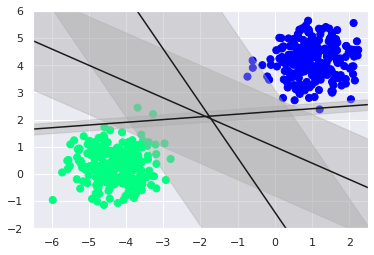

In [28]:
xfit = np.linspace(-6.5, 2.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')

for m, b, d in [(0.1, 2.3, 0.2), (-0.6, 1, 1.8), (-2, -1.4, 4.5)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-6.5, 2.5)
plt.ylim(-2, 6);

各直線のまわりのグレーの幅がマージンです。
マージンとはこのように、その決定境界から各クラスの最も近いデータ点への距離となります。
SVMではこのマージンを最大化するような直線が、新しいデータのクラスの判別に最もよいものとして採用されます。これがSVMのアルゴリズムの中身になります。

実際このグラフ上でも、マージンの一番大きい直線が、どのような位置に新しいデータ点が来たとしても、クラスの判別には一番バランスがとれているであろうことが見てとれます。

## 4. SVMのフィッティングと決定境界の表示

では実際に、このデータセットに対してSVMをフィッティングさせてみます。
その際指定するCパラメータは、採用する決定境界にどれぐらいの誤分類を許すかを表します。
Cパラメータの値は大きければ大きいほど、トレーニングデータの分類に忠実な、"厳しい"決定境界となります。

今回の例のように直線で分割する場合はイメージしづらいですが、曲線などで分割しようとする際は、Cパラメータの値を小さくして、トレーニングデータでの分類に多少の誤りを許した方がよい場合もあります。分割曲線があまり複雑になり過ぎず、新規のデータに対する最終的な判別性能が向上する場合もあるのです。

In [29]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

可視化のために、フィッティングをかけたSVMの決定境界を表示する関数を用意します。

In [30]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

それではSVMが学習した決定境界を表示してみます。

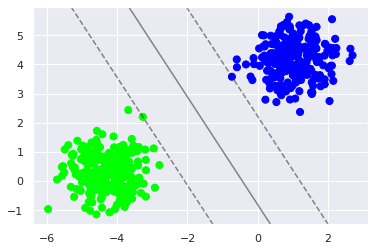

In [31]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='brg')
plot_svc_decision_function(model);

この実線が、SVMが学習した、このデータセットでのマージン(点線までの距離)を最大化する直線(決定境界)ということになります。
このようにして、SVMは学習を行います。

## 5. 異なるトレーニングデータ数での結果の比較

以下を実行することで、このSVMモデルを異なるトレーニングデータ数でフィッティングしたときの結果をインタラクティブに見ることができます。

最終行のN=[]の中の数字を変えることで、好きなデータ数での結果を見比べることができます。
ぜひいろいろと試してみて、決定境界の変化を追ってみてください。

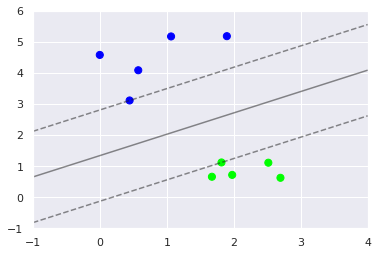

In [32]:
def plot_svm(N=0, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='brg')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)
    
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 50, 100, 200], ax=fixed(None));